In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from matplotlib.pylab import rcParams
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


%matplotlib inline
warnings.filterwarnings("ignore")
rcParams['figure.figsize']=20,10
coin = "ETH-USD"

In [32]:
df=pd.read_csv(f"./data/{coin}.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-07-07,1847.512573,1876.963257,1832.025391,1870.602539,1870.602539,6468885150
1,2023-07-08,1871.002075,1872.501587,1844.641724,1865.539551,1865.539551,4299007854
2,2023-07-09,1865.594971,1878.668945,1857.748291,1863.009766,1863.009766,4392863807
3,2023-07-10,1863.240234,1905.460815,1848.777222,1880.556396,1880.556396,6336468234
4,2023-07-11,1880.654907,1889.381714,1863.218628,1878.336060,1878.336060,4905225892


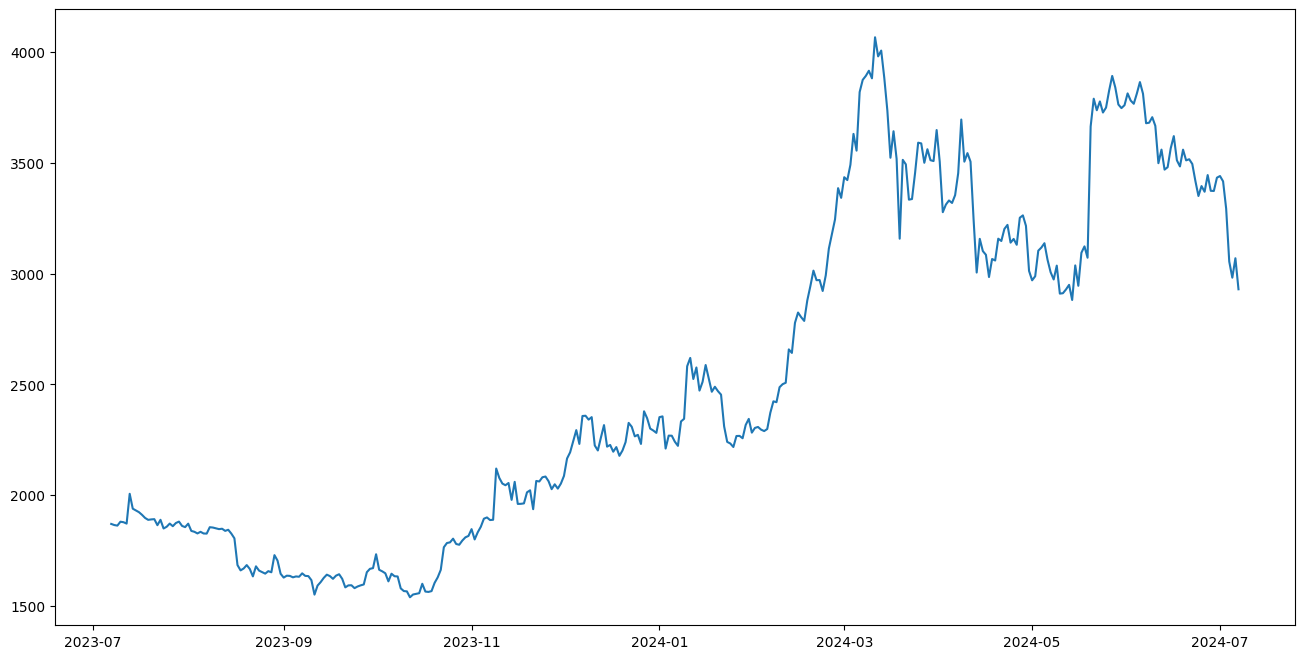

In [33]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [34]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

In [35]:
training_ratio=0.8
training_size=int(len(new_dataset)*training_ratio)

In [36]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values
train_data=final_dataset[0:training_size,:]
valid_data=final_dataset[training_size:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]
prediction_days = 60

for i in range(prediction_days,len(train_data)):
    x_train_data.append(scaled_data[i-prediction_days:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [37]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-prediction_days:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

233/233 - 3s - loss: 0.0120 - 3s/epoch - 13ms/step


In [38]:
X_test=[]
for i in range(prediction_days,inputs_data.shape[0]):
    X_test.append(inputs_data[i-prediction_days:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

3/3 [==============================] - 0s 5ms/step


In [39]:
lstm_model.save(f"./model/{coin}.h5")

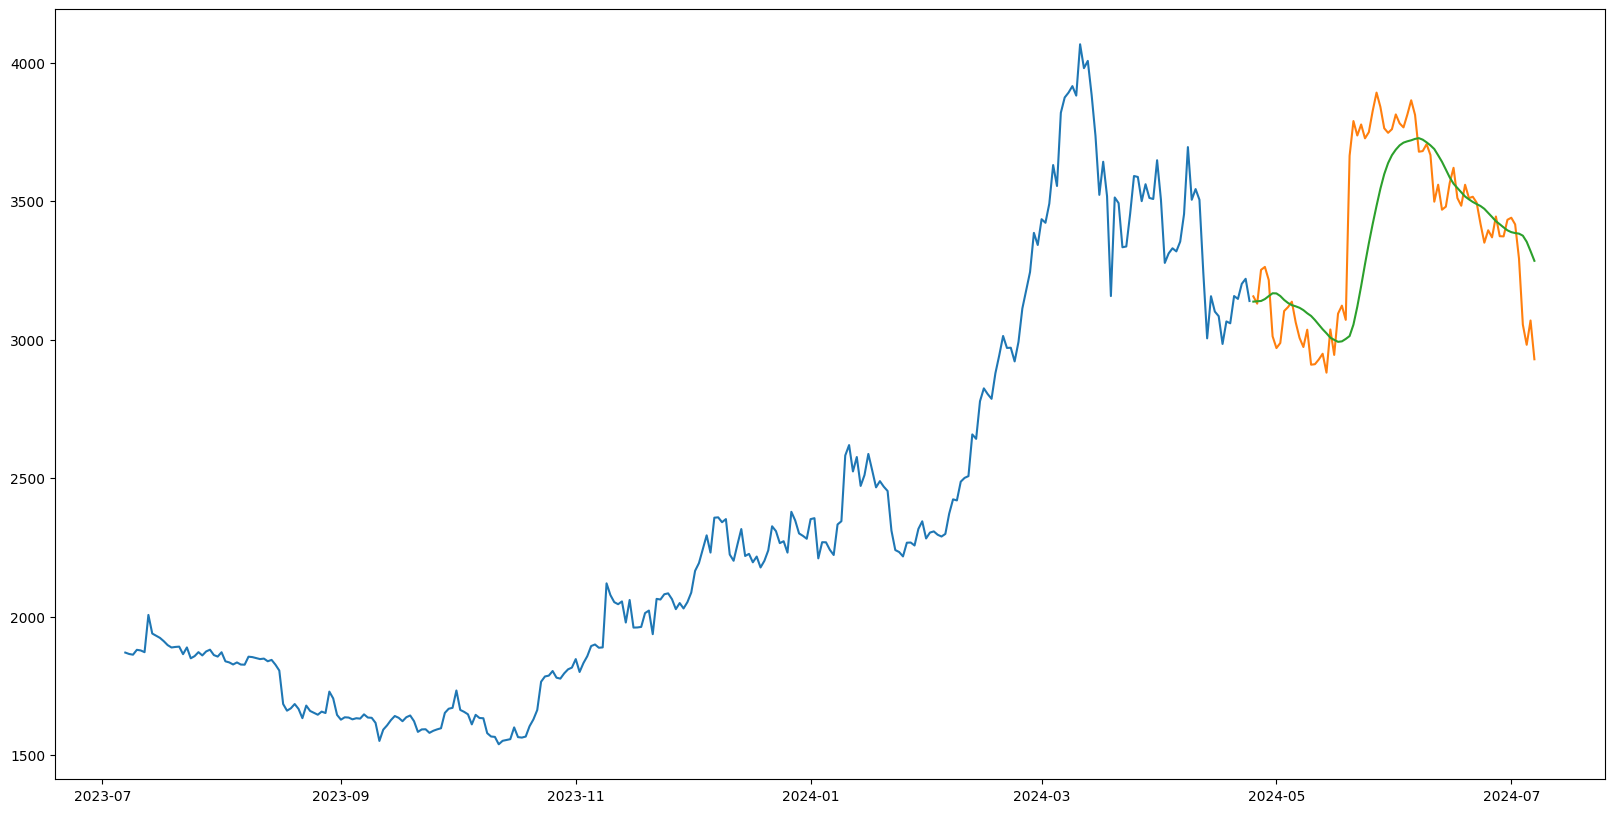

In [40]:
train_data=new_dataset[:training_size]
valid_data=new_dataset[training_size:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])